# Model 0.09 - XGBoost
- Ran some tests on hyperparameters and graphed results
- Tried CV within combination of best hyperparametes, but took too long and results were poor
- Need to go grid search, but at least I know where ball park is for some of the parameters
- I estimate looking at the graphs I could probably squeeze an extra 5 pct points out of the model
- For now I have left the parameters as they were
- I decided to go back to model optimisation after I've completed feature engineering on description/images

In [20]:
import warnings
warnings.simplefilter("ignore")

In [25]:
import re
import ml_metrics
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
rnd = 42  # random state for scoring consistency

## Importing the data

In [3]:
df_train = pd.read_csv("../input/train/train.csv", index_col="PetID")
df_test = pd.read_csv("../input/test/test.csv", index_col="PetID")
df_breeds = pd.read_csv("../input/breed_labels.csv", index_col="BreedID")
df_colors = pd.read_csv("../input/color_labels.csv")

In [4]:
colors = df_colors['ColorID']
breeds = df_breeds.index

## Functions

In [5]:
def apply_word_flags(df, words):
    """Creates binary columns for words which appear in the description"""
    for word in words:
        df[word] = 0
    for i, desc in df['Description'].items():
        try:
            for word in desc.split():
                word = word.lower()
                if word in words:
                    df.at[i,word] = 1
        except AttributeError:
            continue
    return df.drop(columns=['Description'])

In [6]:
keywords = ['home', 'good' , 'adopt', 'loving', 'give', 'looking', 'playful', 'rescued', 'cat', 'contact']

In [7]:
def apply_color_flags(df, colors):
    """Combines Colors 1,2 & 3 into binary columns for each possible colours"""
    for c in colors:
        df[f'C{c}'] = 0
    for i,colors in df[['Color1', 'Color2', 'Color3']].iterrows():
        for c in colors:
            if c != 0:
                df.at[i,f'C{c}'] = 1
    df = df.drop(columns=['Color1', 'Color2', 'Color3'])
    return df

In [8]:
def create_breed_keywords(df):
    """Creates unique list of keywords from provided breeds dataframe"""
    breed_keywords = []
    for breed in df['BreedName']:
        breed = re.sub(r'[/(/)]', '', breed)  # remove braces
        keywords = breed.split()
        breed_keywords += keywords
    return set(breed_keywords)

In [9]:
def apply_breed_flags(df, keywords, breeds):
    """Creates binary columns for keywords which appear in the breed name"""
    for word in keywords:
        df[word] = 0
        
    for i,pair in df[['Breed1', 'Breed2']].iterrows():
        for indx in pair:
            if indx == 0: continue
            breed = breeds.loc[indx,'BreedName']
            breed = re.sub(r'[/(/)]', '', breed)
            new_keywords = breed.split()
            for word in new_keywords:
                if word in keywords: 
                    df.at[i,word] = 1
                    
    return df

## Preparing training data

In [10]:
# Combine test and training data
df_combined = pd.concat([df_test, df_train], sort=False)
df_combined['test'] = df_combined['AdoptionSpeed'].isna()

# Rescuer
rescue_map = Counter(df_combined['RescuerID'])
rescuer_counts = df_combined['RescuerID'].map(rescue_map)

# Breeds
all_test_breeds = df_test['Breed1'].append(df_test['Breed2'])
df_test_breeds = df_breeds.loc[all_test_breeds[all_test_breeds > 0].unique(), :]
breed_keywords = create_breed_keywords(df_test_breeds)

# Prepare data for modelling 
df_combined['rescuer_counts'] = rescuer_counts
df_combined = apply_word_flags(df_combined, keywords)
df_combined = apply_color_flags(df_combined, colors)
df_combined = apply_breed_flags(df_combined, breed_keywords, df_breeds)
df_combined = pd.get_dummies(df_combined, columns=['Gender',
                                                   'Vaccinated', 'Dewormed', 'Sterilized', 
                                                   'State'])
y_train_all = df_combined['AdoptionSpeed'][df_combined['test'] != 1]
X_all       = df_combined.drop(columns=['Name', 'RescuerID', 'AdoptionSpeed', 'Breed1', 'Breed2'])
X_train_all = X_all[X_all['test'] != 1].drop(columns=['test'])
X_test_all  = X_all[X_all['test'] == 1].drop(columns=['test'])

## Test XGBoost model

In [72]:
params = {'max_depth': 4, 
          'learning_rate': 0.2, 
          'n_estimators': 200, 
          'silent': True, 
          'objective': 'multi:softprob', 
          'booster': 'gbtree', 
          'n_jobs': 3,
          'gamma': 0, 
          'min_child_weight': 1, 
          'max_delta_step': 0, 
          'subsample': 0.8, 
          'colsample_bytree': 1, 
          'colsample_bylevel': 1, 
          'reg_alpha': 0, 
          'reg_lambda': 1, 
          'scale_pos_weight': 1, 
          'base_score': 0.2, 
          'random_state': rnd, 
          'missing': None,}

In [69]:
def cv_testing(X_train_all, params, folds=5):

    scores = []

    folds = KFold(folds, True, rnd).split(X_train_all)

    for train_indx, test_indx in folds:

        X_train, X_test = X_train_all.iloc[train_indx], X_train_all.iloc[test_indx]
        y_train, y_test = y_train_all.iloc[train_indx], y_train_all.iloc[test_indx]


        clf = xgb.XGBClassifier(**params)

        clf.fit(X_train, y_train)

        prediction = clf.predict(X_test)

        scores.append(ml_metrics.quadratic_weighted_kappa(rater_a=y_test, rater_b=prediction))
        print("{:.3f}".format(scores[-1]), end="\t")
    
    print()
    
    return scores

In [54]:
def test_hyperparams(p, rng, params, X_train_all):
    
    params = params.copy()
    
    scores = []
    values = []
    for val in rng:
        print(f"parameter {p} = {val}")
        params[p] = val
        score = cv_testing(X_train_all, params)
        scores += score
        values += [val] * len(score)
        
    return values, scores

parameter max_depth = 3
0.326	0.297	0.325	0.305	0.292	
parameter max_depth = 4
0.366	0.313	0.348	0.328	0.330	
parameter max_depth = 5
0.376	0.336	0.355	0.348	0.339	
parameter max_depth = 6
0.375	0.351	0.351	0.352	0.344	
parameter max_depth = 7
0.374	0.362	0.361	0.364	0.359	
parameter max_depth = 8
0.388	0.363	0.360	0.345	0.357	
parameter max_depth = 9
0.391	0.349	0.367	0.359	0.377	


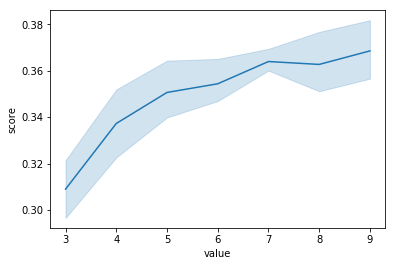

In [58]:
# max depth (start 5/6; optimal 7)
values, scores = test_hyperparams('max_depth', [3,4,5,6,7,8,9], params, X_train_all)
df_graph = pd.DataFrame({'value': values, 'score': scores})
ax = sns.lineplot(x='value', y='score', data=df_graph)

parameter learning_rate = 0.1
0.348	0.316	0.323	0.331	0.312	
parameter learning_rate = 0.3
0.361	0.329	0.362	0.342	0.349	
parameter learning_rate = 0.5
0.366	0.349	0.373	0.355	0.345	
parameter learning_rate = 0.7
0.385	0.361	0.357	0.356	0.356	
parameter learning_rate = 0.9
0.382	0.365	0.355	0.334	0.338	


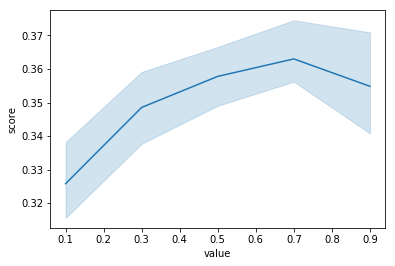

In [61]:
# learning rate (optimal 0.7; decrease 0.9)
values, scores = test_hyperparams('learning_rate', [0.1, 0.3, 0.5, 0.7, 0.9], params, X_train_all)
df_graph = pd.DataFrame({'value': values, 'score': scores})
ax = sns.lineplot(x='value', y='score', data=df_graph)

parameter n_estimators = 50
0.377	0.352	0.357	0.354	0.357	
parameter n_estimators = 100
0.396	0.379	0.372	0.364	0.365	
parameter n_estimators = 200
0.399	0.390	0.374	0.382	0.370	
parameter n_estimators = 400
0.403	0.409	0.390	0.380	0.381	
parameter n_estimators = 600
0.407	0.403	0.401	0.384	0.369	
parameter n_estimators = 900
0.406	0.400	0.400	0.390	0.371	
parameter n_estimators = 1500
0.392	0.384	0.403	0.382	0.358	


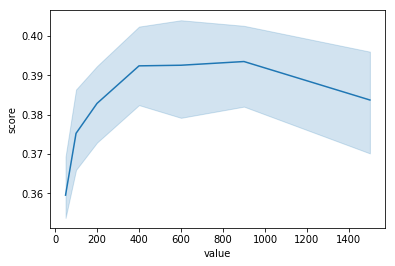

In [60]:
# n_estimators (400 - 900)
values, scores = test_hyperparams('n_estimators', [50,100,200,400,600,900,1500], params, X_train_all)
df_graph = pd.DataFrame({'value': values, 'score': scores})
ax = sns.lineplot(x='value', y='score', data=df_graph)

parameter gamma = 0
0.366	0.313	0.348	0.328	0.330	
parameter gamma = 0.5
0.369	0.318	0.348	0.330	0.332	
parameter gamma = 1
0.366	0.314	0.345	0.329	0.322	
parameter gamma = 2
0.356	0.314	0.352	0.338	0.322	


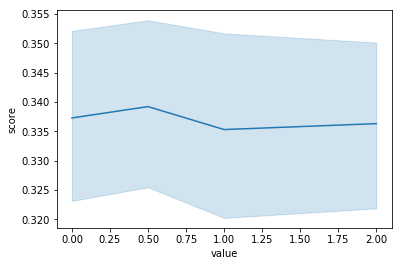

In [62]:
# gamma part 1 (~0.5)
values, scores = test_hyperparams('gamma', [0,0.5,1,2], params, X_train_all)
df_graph = pd.DataFrame({'value': values, 'score': scores})
ax = sns.lineplot(x='value', y='score', data=df_graph)

parameter gamma = 0
0.366	0.313	0.348	0.328	0.330	
parameter gamma = 2
0.356	0.314	0.352	0.338	0.322	
parameter gamma = 4
0.353	0.318	0.345	0.330	0.330	
parameter gamma = 6
0.343	0.312	0.351	0.330	0.324	
parameter gamma = 8
0.333	0.303	0.333	0.319	0.302	
parameter gamma = 10
0.315	0.288	0.323	0.297	0.284	


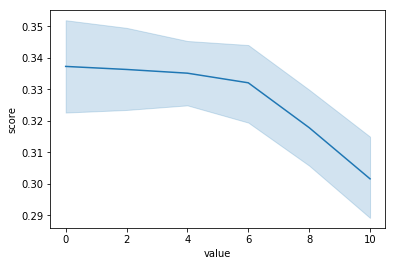

In [64]:
# gamma part 2 (~0)
values, scores = test_hyperparams('gamma', [0,2,4,6,8,10], params, X_train_all)
df_graph = pd.DataFrame({'value': values, 'score': scores})
ax = sns.lineplot(x='value', y='score', data=df_graph)

parameter subsample = 0.2
0.341	0.327	0.336	0.332	0.303	
parameter subsample = 0.4
0.348	0.326	0.353	0.341	0.322	
parameter subsample = 0.6
0.362	0.328	0.342	0.328	0.328	
parameter subsample = 0.8
0.366	0.313	0.348	0.328	0.330	
parameter subsample = 1
0.358	0.327	0.355	0.339	0.322	


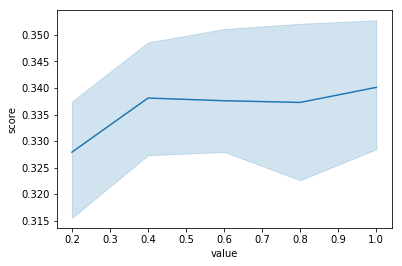

In [66]:
# subsample (0.4 - 0.6)
values, scores = test_hyperparams('subsample', [.2,.4,.6,.8,1], params, X_train_all)
df_graph = pd.DataFrame({'value': values, 'score': scores})
ax = sns.lineplot(x='value', y='score', data=df_graph)

In [71]:
scores = cv_testing(X_train_all=X_train_all, folds=10, params=params)

0.312	

KeyboardInterrupt: 

In [13]:
# 0.367 --> 0.389
np.mean(scores)

0.38808985971090854

# Submitting test data

In [14]:
clf = xgb.XGBClassifier(**params)
clf.fit(X_train_all, y_train_all)
prediction = clf.predict(X_test_all)

/home/rich/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [15]:
submission = pd.DataFrame({'AdoptionSpeed': prediction.astype(int)}, index=X_test_all.index)
submission.to_csv("submission.csv", index=True, index_label='PetID', header=['AdoptionSpeed'])